In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')
from modules.data_import import *
from modules.basics import *
import copy
from typing import Callable, Tuple
import json
from fastprogress import progress_bar, master_bar
from sklearn.pipeline import Pipeline

from lumin.nn.callbacks.data_callbacks import ParametrisedPrediction

# Import models and data

In [2]:
run_name = '11-24-2021'

In [6]:
ensemble_0 = Ensemble.from_save(f'weights/selected_set_0_{run_name}')
ensemble_1 = Ensemble.from_save(f'weights/selected_set_1_{run_name}')

In [7]:
PATH = Path('../../../MC/')

In [8]:
set_0_fy = FoldYielder(PATH/'test_0_untrained.hdf5', input_pipe=PATH/'input_pipe_0_untrained.pkl')
set_1_fy = FoldYielder(PATH/'test_1_untrained.hdf5', input_pipe=PATH/'input_pipe_1_untrained.pkl')

# Apply models

In [9]:
def lookup_mass(m, pipe):
    idx = train_feats.index('res_mass')
    m *= pipe[0].scale_[idx]
    m += pipe[0].mean_[idx]
    return int(round(2*m,-1)/2)

In [10]:
def preprocess_mass(m, pipe):
    idx = set_0_fy.cont_feats.index('res_mass')
    m -= pipe[0].mean_[idx]
    m /= pipe[0].scale_[idx]
    return m

In [11]:
masses = sorted([int(m) for m in set(set_0_fy.get_column('res_mass_orig'))])

In [12]:
masses

[900]

In [13]:
# spins = [0,1]; spins

In [14]:
train_feats = set_0_fy.cont_feats+set_0_fy.cat_feats; train_feats

['Higgsbb_cand_pt',
 'Zjet_cand_pt',
 'leading_Hbb_pt',
 'trailing_Hbb_pt',
 'leading_jet_pt',
 'trailing_jet_pt',
 'Higgsbb_cand_mass',
 'HiggsZZ_cand_mass',
 'Zlep_cand_mass',
 'Zjet_cand_mass',
 'Zlep_cand_pt',
 'dR_l1j1',
 'dR_l1j2',
 'dR_l1b1',
 'dR_l1b2',
 'dR_l2j1',
 'dR_l2j2',
 'dR_l2b1',
 'dR_l2b2',
 'dR_j1j2',
 'dR_b1b2',
 'res_mass']

In [15]:
"""
Only run this if you are predicting on a folder yielder for the first time
"""

mb = master_bar(masses)
for m in mb:
    for e, fy_s, pipe in ((ensemble_0, set_1_fy, set_0_fy.input_pipe),
                            (ensemble_1, set_0_fy, set_1_fy.input_pipe)):
        mass_param = ParametrisedPrediction(train_feats, ['res_mass'], [preprocess_mass(m,pipe)])
        e.predict(fy_s,cbs=[mass_param],verbose=False,
                    pred_name=f'pred_mass_{m}')

# Check results

## Get dataframes

In [16]:
set_0_fy

FoldYielder with 10 folds, containing ['gen_strat_key', 'inputs', 'pred_mass_900', 'res_mass_orig', 'targets', 'weights']

In [17]:
# def load_df(fy:FoldYielder, mass:float, spin:str) -> pd.DataFrame:
#     df = fy.get_df(pred_name=f'pred_mass_{mass}_{spin}', inc_inputs=True, verbose=False)
#     for c in df.year.unique(): df.loc[df.year == c, 'year'] = id2year[c]
#     df['gen_sample']    = fy.get_column('gen_sample')
#     df['channel']       = fy.get_column('channel')
#     df['jet_cat']       = fy.get_column('jet_cat')
#     df['res_mass_orig'] = fy.get_column('res_mass_orig')
#     df = df[(df.gen_target==0)|((df.res_mass_orig==mass)&(df.spin==spin2id[spin]))]
#     for c in set(df.gen_sample): df.loc[df.gen_sample == c, 'gen_sample'] = id2sample[c]
#     for c in set(df['channel']): df.loc[(df.channel == c) & (df.gen_target == 1), 'gen_sample'] = df.loc[(df.channel == c) & (df.gen_target == 1), 'gen_sample']+r'$\rightarrow$'+id2channel[c]
#     for c in set(df['jet_cat']): df.loc[(df.jet_cat == c), 'jet_cat'] = id2jet[c]
#    return df

def load_df(fy:FoldYielder, mass:float) -> pd.DataFrame:
    df = fy.get_df(pred_name=f'pred_mass_{mass}', inc_inputs=True, verbose=False)
    df['res_mass_orig'] = fy.get_column('res_mass_orig')
    df = df[(df.gen_target==0)|(df.res_mass_orig==mass)]
    return df

In [18]:
df = load_df(set_0_fy, 900).append(load_df(set_1_fy, 900), ignore_index=True); df.head()

,Higgsbb_cand_pt,Zjet_cand_pt,leading_Hbb_pt,trailing_Hbb_pt,leading_jet_pt,trailing_jet_pt,Higgsbb_cand_mass,HiggsZZ_cand_mass,Zlep_cand_mass,Zjet_cand_mass,...,dR_l2j2,dR_l2b1,dR_l2b2,dR_j1j2,dR_b1b2,res_mass,gen_target,gen_weight,pred,res_mass_orig
0,-0.799302,0.444516,-0.491452,-0.698067,0.460114,-0.364263,-0.193596,0.473499,-1.426966,0.972308,...,0.957201,0.060342,-0.413806,0.789181,0.801648,0.0,1,1.0,0.268040,900.0
1,1.133852,0.842356,1.297197,0.014256,1.424769,-0.069209,-0.096307,0.862394,0.530684,0.517855,...,-0.433928,0.651916,0.077690,0.540493,-1.026678,0.0,1,1.0,0.960301,900.0
2,2.025697,3.450021,1.968419,0.582756,3.200379,1.447620,-0.168092,0.369412,0.361125,0.794377,...,0.372901,0.457152,0.020512,-0.946508,-1.247673,0.0,1,1.0,0.538847,900.0
3,-0.726026,0.894948,-0.386448,-0.624847,0.171485,1.836351,-0.196546,-0.781057,0.037243,-0.400042,...,-1.729078,-0.717032,0.127616,-1.385367,0.478574,0.0,1,1.0,0.922499,900.0
4,0.655304,-0.068347,0.097153,0.650882,-0.136339,0.924294,-0.193856,-0.622546,-1.748790,-0.113522,...,0.461076,0.475478,1.142820,-0.371573,-0.981087,0.0,1,1.0,0.999486,900.0


## Unity-weighted plots

### Overall

In [19]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
bins = 20

# make class prediction plot
def make_cp(df):
    plt.figure()
    plt.hist(df.loc[df.gen_target == 1].pred, bins, stacked=True, density = True, log = False, alpha = 0.5, label='signal')
    plt.hist(df.loc[df.gen_target == 0].pred, bins, stacked=True, density = True, log = False, alpha = 0.5, label='background')
    plt.legend(loc='best')
    plt.xlabel('Class Prediction')
    plt.ylabel('Frequency')
    plt.show()

# make roc plot
def make_roc(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

mass:  900


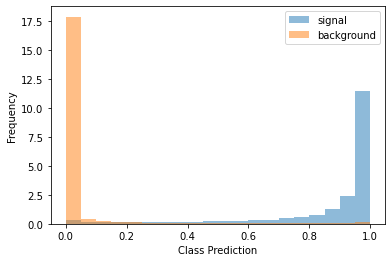

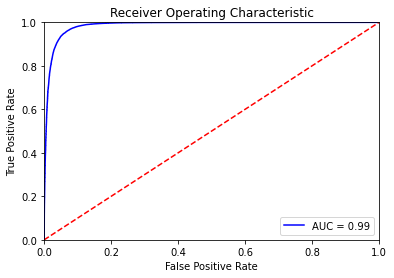

In [20]:
roc_scores = []
for mass in masses:
    df = load_df(set_0_fy, mass).append(load_df(set_1_fy, mass), ignore_index=True)
    print('mass: ', mass)
    make_cp(df)
    fpr, tpr, threshold = metrics.roc_curve(df.gen_target, df.pred)
    roc_auc = metrics.auc(fpr, tpr)
    roc_scores.append(roc_auc)
    make_roc(fpr, tpr, roc_auc)

(250.0, 1010.0, 0.85, 1.0)

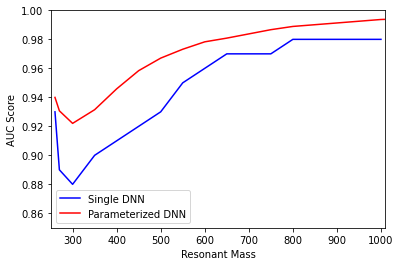

In [18]:
"""
Compare singley-trained Binary Classification network to Parameterized network
"""
mass = [260, 270, 300, 350, 400, 450, 500, 550, 600, 650, 750, 800, 900, 1000]
SNN_AUC = [0.93, 0.89, 0.88, 0.90, 0.91, 0.92, 0.93, 0.95, 0.96, 0.97, 0.97, 0.98, 0.98, 0.98]

single, = plt.plot(mass, SNN_AUC, 'b', Label='Single DNN')
parameterized, = plt.plot(masses, roc_scores, 'r', Label='Parameterized DNN')

plt.legend(handles=[single, parameterized])
plt.xlabel('Resonant Mass')
plt.ylabel('AUC Score')
plt.axis([250, 1010, 0.85, 1])

### By channel

In [ ]:
print('Tau Tau')
plot_binary_class_pred(df[df.channel==0], wgt_name='gen_weight')
print('Mu Tau')
plot_binary_class_pred(df[df.channel==1], wgt_name='gen_weight')
print('E Tau')
plot_binary_class_pred(df[df.channel==2], wgt_name='gen_weight')

### By year

In [ ]:
for y in df.year.unique():
    print(y)
    plot_binary_class_pred(df[df.year==y], wgt_name='gen_weight')

### By jet category

#### Tau Tau

In [ ]:
channel_df = df[df.channel==0]
for c in sorted(df.jet_cat.unique()):
    print(c)
    plot_binary_class_pred(channel_df[channel_df.jet_cat==c], wgt_name='gen_weight')

#### Mu Tau

In [ ]:
channel_df = df[df.channel==1]
for c in sorted(df.jet_cat.unique()):
    print(c)
    plot_binary_class_pred(channel_df[channel_df.jet_cat==c], wgt_name='gen_weight')

#### E Tau

In [ ]:
channel_df = df[df.channel==2]
for c in sorted(df.jet_cat.unique()):
    print(c)
    plot_binary_class_pred(channel_df[channel_df.jet_cat==c], wgt_name='gen_weight')

## Plot signal region

In [ ]:
sorted(df.jet_cat.unique())

In [ ]:
use_cats = ['2j1b VBF', '2j1bR noVBF', '2j2LbB noVBF', '2j2bR noVBF']

In [ ]:
def get_max_unc(year:int, channel:int, jet_cat:str) -> float:
    if jet_cat == '2j1b VBF': return 0.1
    if jet_cat == '2j2LbB noVBF': return 0.3
    return 0.05

In [ ]:
def plot_channel_category_dists(df:pd.DataFrame, unc_func:Callable[[int,str],float]=get_max_unc,
                                settings:PlotSettings=PlotSettings(), density:bool=False,
                                bins:Dict[str,List[float]]=None) -> Dict[str,List[float]]:
    if bins is None: bins = {}
    for y in df.year.unique():
        for c in df['channel'].unique():
            for j in use_cats:
                if f'{y}_{c}_{j}' not in bins:
                    max_unc = unc_func(y, c, j)
                    tmp_df = df[(df.year == y)&(df.channel == c)&(df.jet_cat == j)]
                    if len(tmp_df) > 0:
                        edges = bin_binary_class_pred(tmp_df, max_unc, compact_samples=True, verbose=True)
                        bins[f'{y}_{c}_{j}'] = list(edges)
                        tmp_settings = copy.copy(settings)
                        tmp_settings.title += f' {y:.0f} {j}'
                        plot_sample_pred(tmp_df, bins=bins[f'{y}_{c}_{j}'], density=density,
                                         settings=tmp_settings)
                    else:
                        print(f'{y} {c} {j} no events')
    return bins

In [ ]:
bins = plot_channel_category_dists(df, unc_func=get_max_unc, settings=plot_settings, density=False)

# AMS

In [ ]:
def bin_channel_category_dists(df:pd.DataFrame, unc_func:Callable[[int,str],float]=get_max_unc) -> Dict[str,List[float]]:
    bins = {}
    for y in df.year.unique():
        for c in df['channel'].unique():
            for j in use_cats:
                if f'{y}_{c}_{j}' not in bins:
                    max_unc = unc_func(y, c, j)
                    tmp_df = df[(df.year == y)&(df.channel == c)&(df.jet_cat == j)]
                    if len(tmp_df) > 0:
                        edges = bin_binary_class_pred(tmp_df, max_unc, compact_samples=True, verbose=False)
                        bins[f'{y}_{c}_{j}'] = list(edges)
                    else:
                        print(f'{y} {c} {j} no events')
    return bins

In [ ]:
def get_ams(bin_cut:float, df:pd.DataFrame, syst_b:float=0.1) -> None:
    cut_df = df[df.pred >= bin_cut]
    ams = calc_ams(cut_df.loc[cut_df.gen_target==1, 'gen_weight'].sum(),
                   cut_df.loc[cut_df.gen_target==0, 'gen_weight'].sum(),
                   unc_b=np.sqrt((syst_b*syst_b)+(1/(len(cut_df.loc[cut_df.gen_target==0, 'gen_weight'])))))
    return ams if ams > 0 else 0

In [ ]:
def quad_sum_ams(df:pd.DataFrame, bins:Dict[str,np.ndarray]) -> float:
    ams = 0
    for y in df.year.unique():
        for c in df['channel'].unique():
            for j in use_cats:
                ams += np.square(get_ams(bins[f'{y}_{c}_{j}'][-2], df[(df.channel==c)&(df.jet_cat==j)&(df.year==y)]))
    return np.sqrt(ams)

In [ ]:
def score_mass_range(masses:List[float], spins:List[int]) -> str:
    pt = PrettyTable(['Res. Mass']+[id2spin[s] for s in spins])
    results = ['' for _ in spins]
    for mass_id in progress_bar(masses):
        row = [mass_id]
        for i, spin_id in enumerate(spins):
            df = load_df(set_0_fy, mass_id, id2spin[spin_id]).append(load_df(set_1_fy, mass_id, id2spin[spin_id]), ignore_index=True)
            bins = bin_channel_category_dists(df, unc_func=get_max_unc)
            ams = quad_sum_ams(df, bins)
            row.append(ams)
            results[i] += f'{ams:.3f}\t'
        pt.add_row(row)
    print(pt)
    print(results)
    return results

In [ ]:
score_mass_range(masses[::4], spins)